In [1]:
# !pip install --upgrade pip
# !pip install pandas
# !cp ./fp_refined.csv /data

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


import pandas as pd

from tqdm import tnrange, tqdm_notebook


tf.enable_eager_execution()

# floorplan

In [3]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

In [4]:
def _parse_predict_function(example_proto):
    # Create a description of the features.
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        "floorplan": tf.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        "is_area_85": tf.FixedLenFeature([], tf.int64, default_value=0),
        "is_core": tf.FixedLenFeature([], tf.int64, default_value=0),
        "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)

    return (
        parsed_example["floorplan"],
        parsed_example["plan_id"],
        parsed_example["norm_year"],
    )


def create_predict_dataset(filepaths):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(8)

    return dataset


path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

predict_dataset = create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

fps = []
ids = []
for batch in iter:
    fps.extend(batch[0].numpy())
    ids.extend(batch[1].numpy())

ids = [id.decode() for id in ids]

len(fps), fps[0].shape

W1218 10:22:47.625015 140441348458240 deprecation.py:323] From <ipython-input-4-7080ec9cea2c>:48: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(50540, (28, 28, 6))

In [5]:
ids.index("9765_107A")

45898

[[ 0.    0.    0.    0.  ]
 [-1.   -0.67 -1.    1.  ]
 [ 0.   -0.75 -1.    1.  ]
 [-1.   -0.74  0.    1.  ]
 [-0.17 -0.13 -1.    1.  ]
 [-1.   -0.19 -0.24  1.  ]]
(28, 28, 6)
(50540, 28, 28, 4)
[[0.00000006 0.25000004 0.00000006 0.        ]
 [0.         0.25       0.         0.        ]
 [0.00000006 0.25000004 0.00000006 0.        ]
 ...
 [0.         0.25       0.         0.        ]
 [0.         0.25000004 0.00000006 0.        ]
 [0.         0.25       0.         0.        ]]
[[1.         1.         1.         0.99999994]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         0.99999994]
 ...
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]]


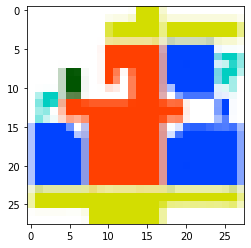

In [39]:
# adjusted for different luminance
channel_to_rgba = np.array(
    [
        [0.0, 0.0, 0.0, 0.0],
        # move ransparancy to each layer
        [0.0, 0.33, 0.0, 1.0],  # entrance to green L30
        [1.0, 0.25, 0.0, 1.0],  # LDK to red L57
        [0.0, 0.26, 1.0, 1.0],  # bedroom to blue L40
        [0.83, 0.87, 0.0, 1.0],  # balcony to yellow L85
        [0.0, 0.81, 0.76, 1.0],
    ]
)  # bathroom to cyan L75

# make colors subtractive
channel_to_rgba[1:6, 0:3] -= 1

print(channel_to_rgba)
print(fps[0].shape)

# put it on transparent white
fps_rgba = np.array([1.0, 1.0, 1.0, 0.0]) + (np.array(fps) @ channel_to_rgba)
print(fps_rgba.shape)

np.set_printoptions(suppress=True)
print(np.amin(fps_rgba, axis=(1, 2)))
print(np.amax(fps_rgba, axis=(1, 2)))


fig = plt.figure()
ax = plt.imshow(fps_rgba[5])

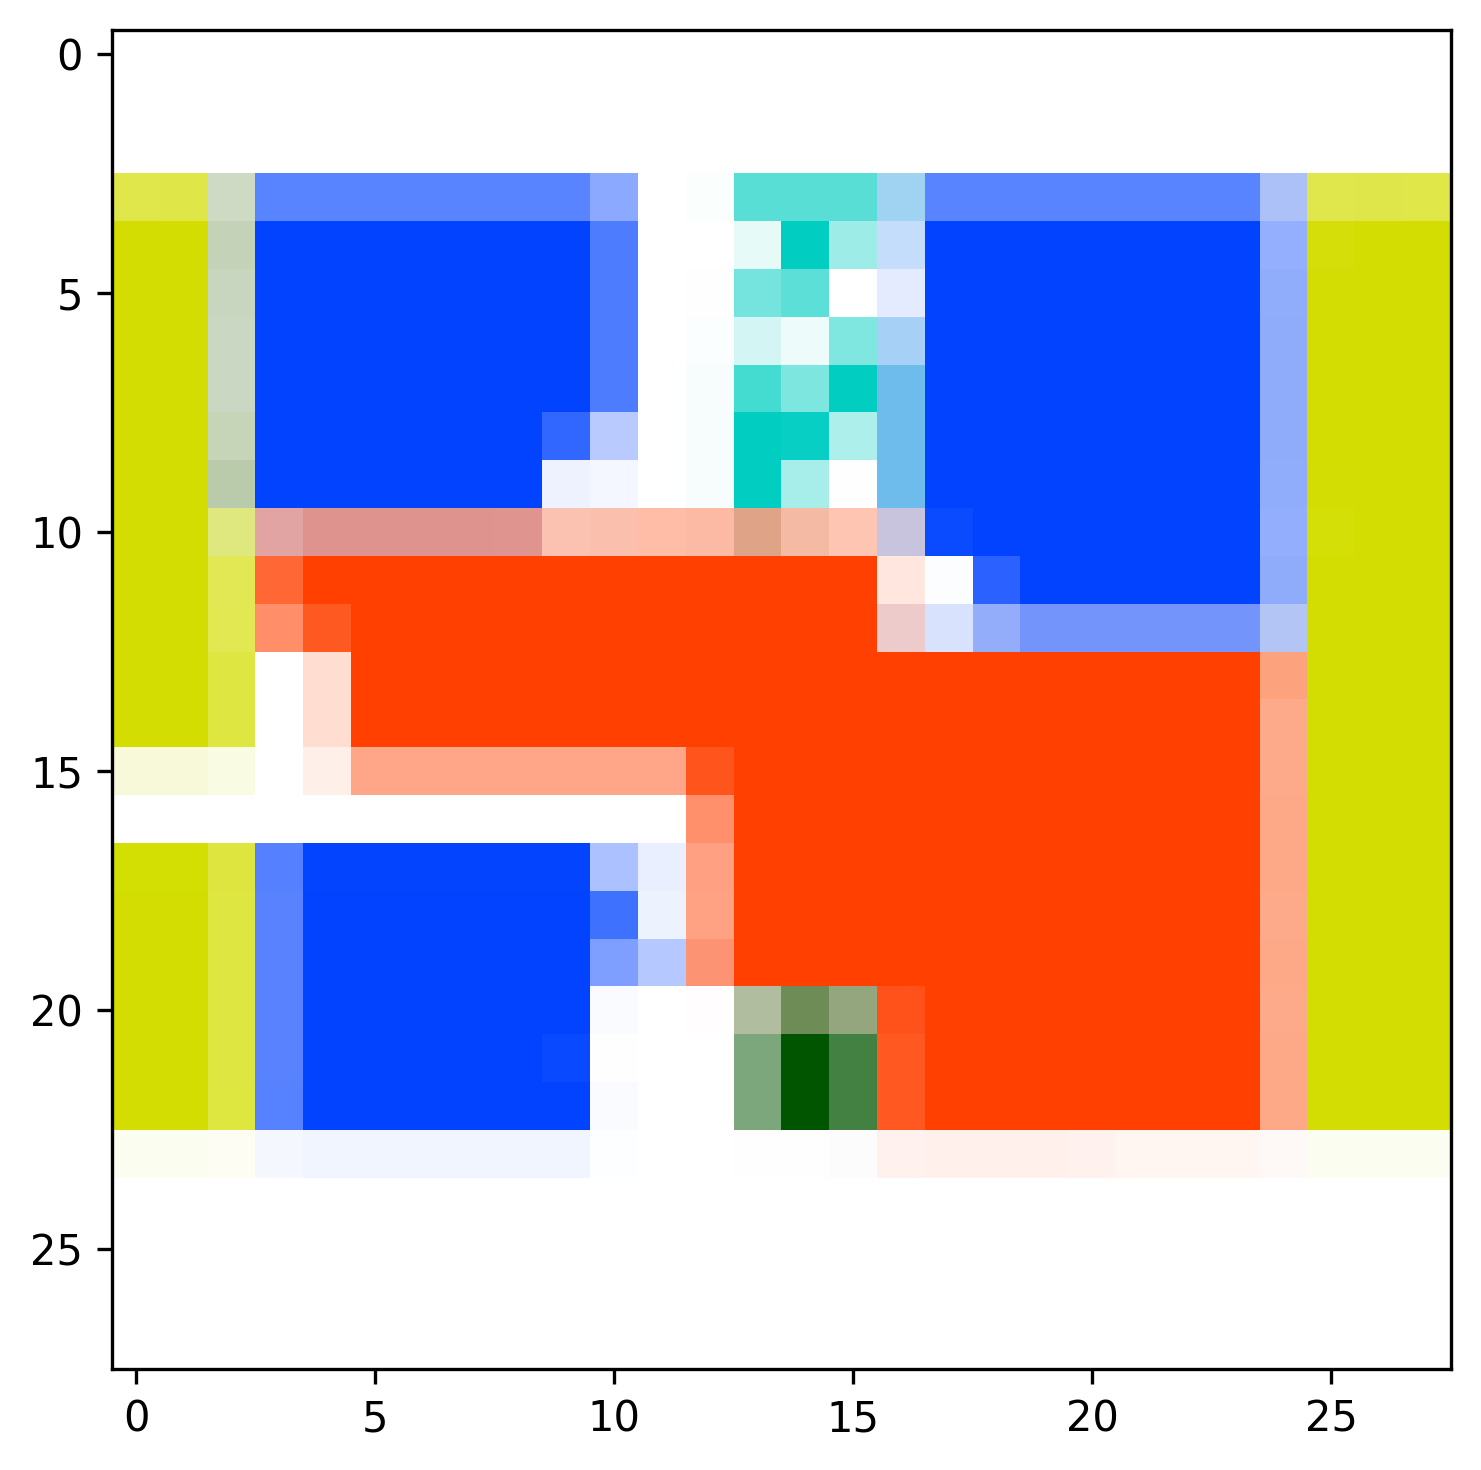

In [43]:
# pit it on white

before = fps_rgba[ids.index("9765_107A")].copy()
# before[:, :, 0:3] *= before[:, :, 3][:, :, np.newaxis]
# before[:, :, 3] = 1


fig = plt.figure(figsize=(5, 5), dpi=300)
ax = plt.imshow(before)
plt.tight_layout()
fig.savefig("dropout_before.pdf")

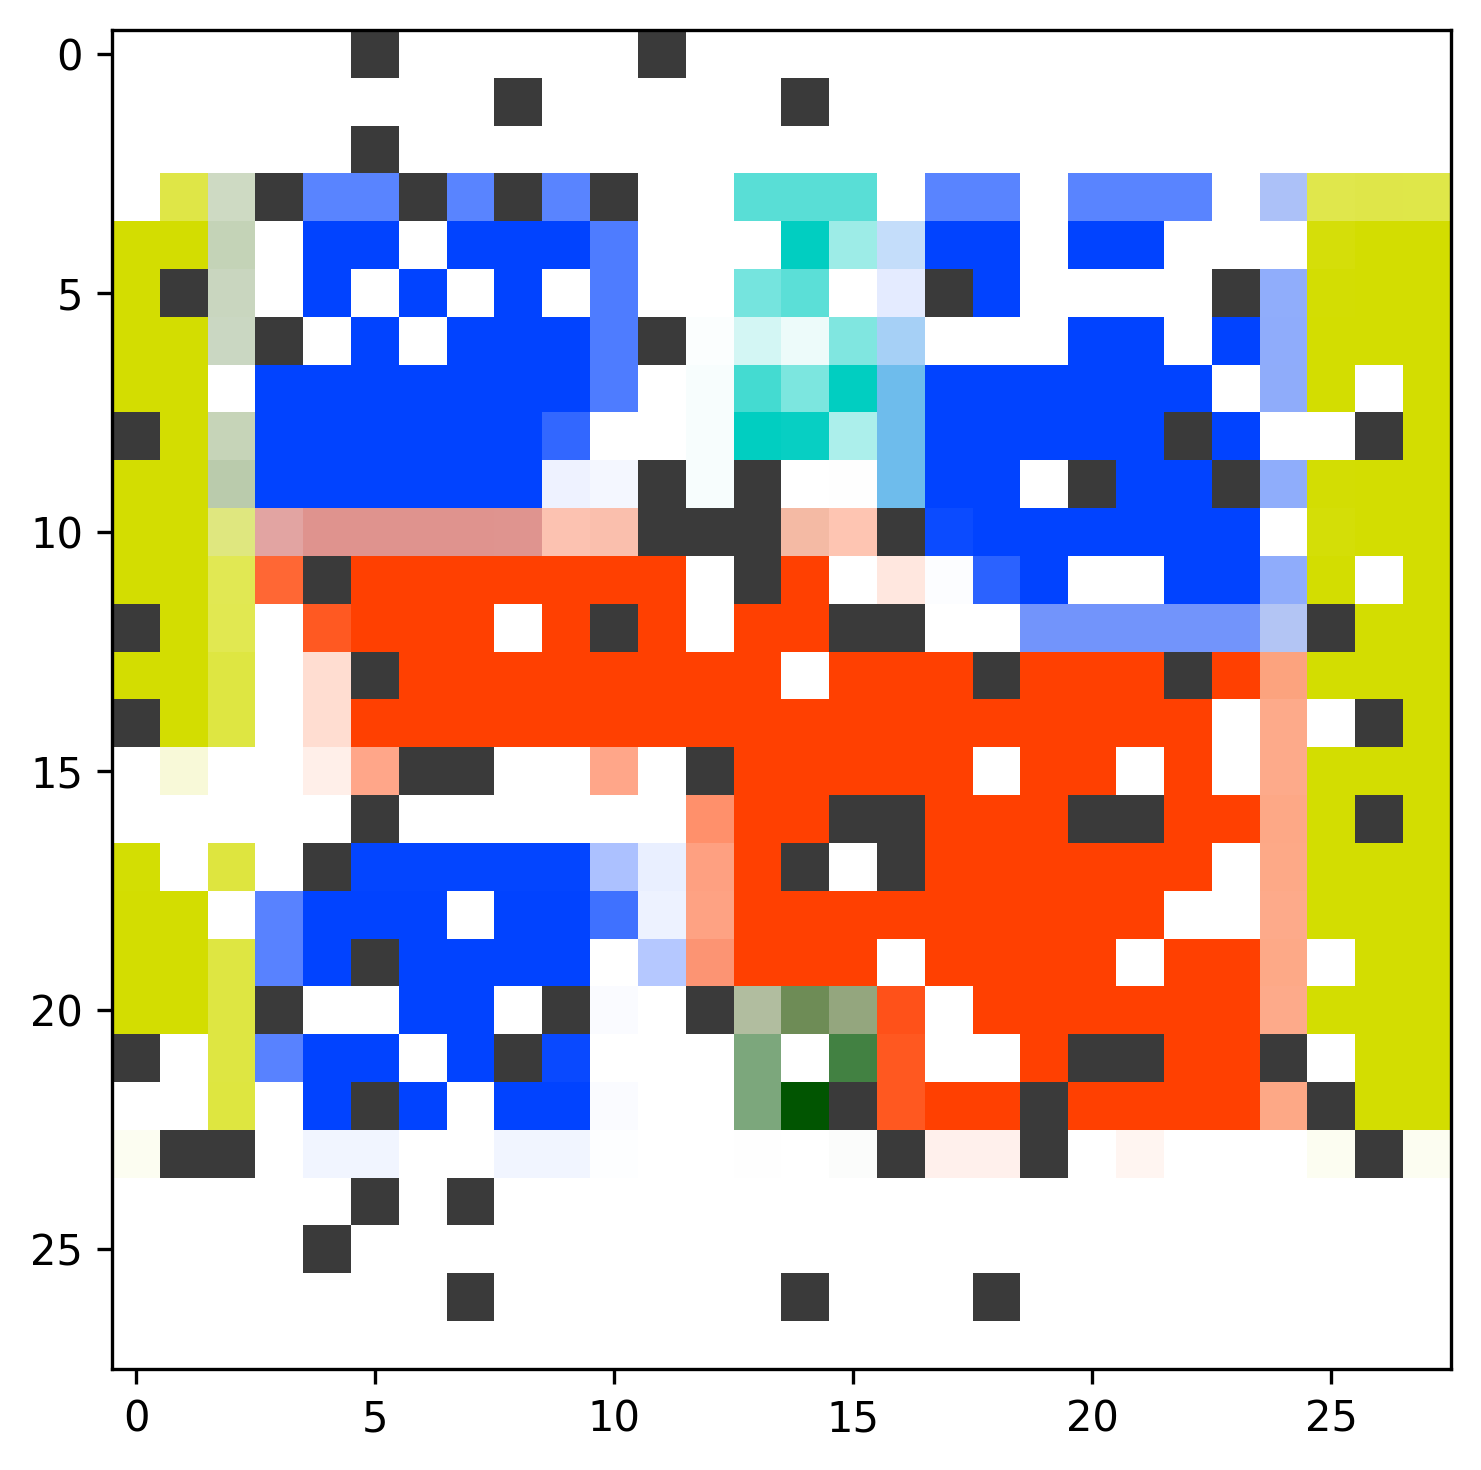

In [75]:
np.random.seed(1106)

after = before.copy()

# 20% no space = white

row, col = 28, 28
coords20 = [np.random.randint(0, i - 1, int(0.2 * row * col)) for i in (28, 28)]
after[tuple(coords20) + (slice(None),)] = [1.0, 1.0, 1.0, 1.0]

# 10% all space = blackish gray

coords10 = [np.random.randint(0, i - 1, int(0.1 * row * col)) for i in (28, 28)]
after[tuple(coords10) + (slice(None),)] = [0.23, 0.23, 0.23, 1.0]

# # 10% all space = inversion

# coords10 = [np.random.randint(0, i - 1, int(0.1 * row * col)) for i in (28, 28)]
# after[tuple(coords10) + (slice(None),)] *= -1
# after[tuple(coords10) + (slice(None),)] += [1.0, 1.0, 1.0, 2.0]
# after = np.clip(after, 0.0, 1.0)

fig = plt.figure(figsize=(5, 5), dpi=300)
ax = plt.imshow(after)
plt.tight_layout()
fig.savefig("dropout_after.pdf")